In [9]:
!git clone https://github.com/apple/ml-depth-pro
!cd ml-depth-pro && pip install -e .

Obtaining file:///Users/ke/Documents/Cal/research/scenic-reasoning/notebooks/ml-depth-pro
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for depth_pro (pyproject.toml) ... done
  Created wheel for depth_pro: filename=depth_pro-0.1-0.editable-py3-none-any.whl size=4814 sha256=687da66b5b36a383dc21f3b1420fc2e19747dc080518fc472d2e8c64a304c933
  Stored in directory: /private/var/folders/x0/4c53w9gj75gbnx5b6fls0kxh0000gn/T/pip-ephem-wheel-cache-8dg8yekw/wheels/0a/2a/27/d85b125242b0c9633e3c3bedea25706ff5a4fde466b0281e31
Successfully built depth_pro
  Attempting uninstall: depth_pro
    Found existing installation: depth_pro 0.1
    Uninstalling depth_pro-0.1:
      Successfully uninstalled depth_pro-0.1


In [6]:
!source ml-depth-pro/get_pretrained_models.sh

--2024-10-25 00:52:41--  https://ml-site.cdn-apple.com/models/depth-pro/depth_pro.pt
Resolving ml-site.cdn-apple.com (ml-site.cdn-apple.com)... 2620:149:a0c:f100::2, 2620:149:a0c:f000::3, 17.253.17.209, ...
Connecting to ml-site.cdn-apple.com (ml-site.cdn-apple.com)|2620:149:a0c:f100::2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1904446787 (1.8G) [binary/octet-stream]
Saving to: ‘checkpoints/depth_pro.pt’

depth_pro.pt        100%[===================>]   1.77G  7.71MB/s    in 4m 48s  

2024-10-25 00:57:29 (6.31 MB/s) - ‘checkpoints/depth_pro.pt’ saved [1904446787/1904446787]



In [2]:
from PIL import Image
import torch
import depth_pro

model, transform = depth_pro.create_model_and_transforms(
    device=torch.device("mps")
)
model.eval()

image, _, f_px = depth_pro.load_rgb("../demo/demo.jpg")
image = transform(image)

prediction = model.infer(image, f_px=f_px)
depth = prediction["depth"] # depth in [m]
depth

tensor([[6.2263, 6.2632, 6.2078,  ..., 8.6583, 8.6216, 8.4727],
        [6.3131, 6.2631, 6.2572,  ..., 8.6530, 8.6475, 8.6311],
        [6.4186, 6.3168, 6.2813,  ..., 8.5946, 8.5880, 8.5650],
        ...,
        [3.5017, 3.4957, 3.4894,  ..., 3.5640, 3.5725, 3.5854],
        [3.4953, 3.4847, 3.4750,  ..., 3.5601, 3.5693, 3.5865],
        [3.5044, 3.4910, 3.4719,  ..., 3.5581, 3.5505, 3.5699]],
       device='mps:0')

In [7]:
import PIL
from matplotlib import pyplot as plt
import numpy as np


def visualize_inverse_depth(depth: torch.Tensor) -> PIL.Image.Image:
    inverse_depth = 1 / depth
    # Visualize inverse depth instead of depth, clipped to [0.1m;250m] range for better visualization.
    max_invdepth_vizu = min(inverse_depth.max(), 1 / 0.1)
    min_invdepth_vizu = max(1 / 250, inverse_depth.min())
    inverse_depth_normalized = (inverse_depth - min_invdepth_vizu) / (
        max_invdepth_vizu - min_invdepth_vizu
    )
    cmap = plt.get_cmap("turbo")
    color_depth = (cmap(inverse_depth_normalized)[..., :3] * 255).astype(
        np.uint8
    )

    return PIL.Image.fromarray(color_depth)

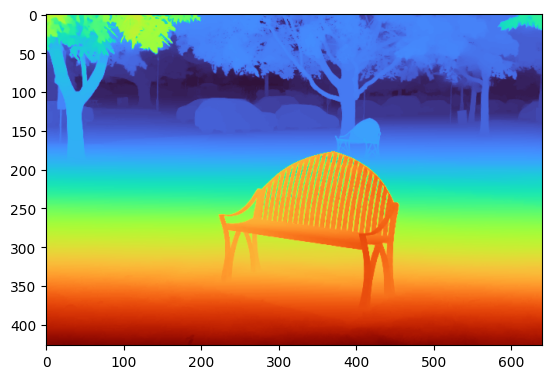

In [10]:
visual_depth = visualize_inverse_depth(depth.cpu())

plt.imshow(visual_depth)

In [3]:
focallength_px = prediction["focallength_px"] # focal length in pixels
focallength_px

tensor(961.0314, device='mps:0')